# El aprendizaje automático ayuda a los agricultores a seleccionar los mejores cultivos
![Farmer in a field](farmer_in_a_field.jpg)

Medir métricas esenciales del suelo, como nitrógeno, fósforo, potasio y pH, es crucial para evaluar su estado. Sin embargo, este proceso puede ser costoso y llevar mucho tiempo, lo que obliga a los agricultores a priorizar según su presupuesto.

Los agricultores deben decidir qué cultivo plantar cada temporada para maximizar el rendimiento, considerando la condición del suelo, que afecta el crecimiento. Cada cultivo tiene condiciones de suelo ideales que garantizan un crecimiento y rendimiento óptimos.

Un agricultor solicita su ayuda como experto en aprendizaje automático para seleccionar el mejor cultivo para su campo. Le proporcionaron un conjunto de datos, soil_measures.csv, que contiene:

"N": Contenido de nitrógeno en el suelo
"P": Contenido de fósforo en el suelo
"K": Contenido de potasio en el suelo
"pH": Valor de pH del suelo
"crop": Valores categóricos de varios cultivos (variable objetivo)

Cada fila representa mediciones del suelo en un campo específico, y el cultivo en la columna "crop" es la opción óptima para ese campo.

En este proyecto, se crearán modelos de clasificación de clases múltiples para predecir el tipo de "crop" e identificar la característica más importante para el rendimiento predictivo.

## 1. Librerías

In [178]:

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

## 2. EDA

In [179]:
# Cargar el archivo
crops = pd.read_csv("soil_measures.csv")

In [180]:
#Funcíon para examinar el df
def df_info(df):
    temp = pd.DataFrame(index=df.columns)
    temp["Datatype"] = df.dtypes
    temp["Not null values"] = df.count()
    temp["Null values"] = df.isnull().sum()
    temp["Percentage of Null values"] = (df.isnull().mean())*100
    temp["Unique count"] = df.nunique()
    return temp

In [181]:
df_info(crops)

,Datatype,Not null values,Null values,Percentage of Null values,Unique count
N,int64,2200,0,0.0,137
P,int64,2200,0,0.0,117
K,int64,2200,0,0.0,73
ph,float64,2200,0,0.0,2200
crop,object,2200,0,0.0,22


La base de datos proporcionada está limpia, estructuralmente no cuenta con datos faltantes. Lo anterior es clave para el proprocesamiento del df, pues quizas no se necesite usar técnica de imputación, pero si estandarización o escalamiento.

In [182]:
crops.describe()

,N,P,K,ph
count,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,6.469480
std,36.917334,32.985883,50.647931,0.773938
min,0.000000,5.000000,5.000000,3.504752
25%,21.000000,28.000000,20.000000,5.971693
50%,37.000000,51.000000,32.000000,6.425045
75%,84.250000,68.000000,49.000000,6.923643
max,140.000000,145.000000,205.000000,9.935091


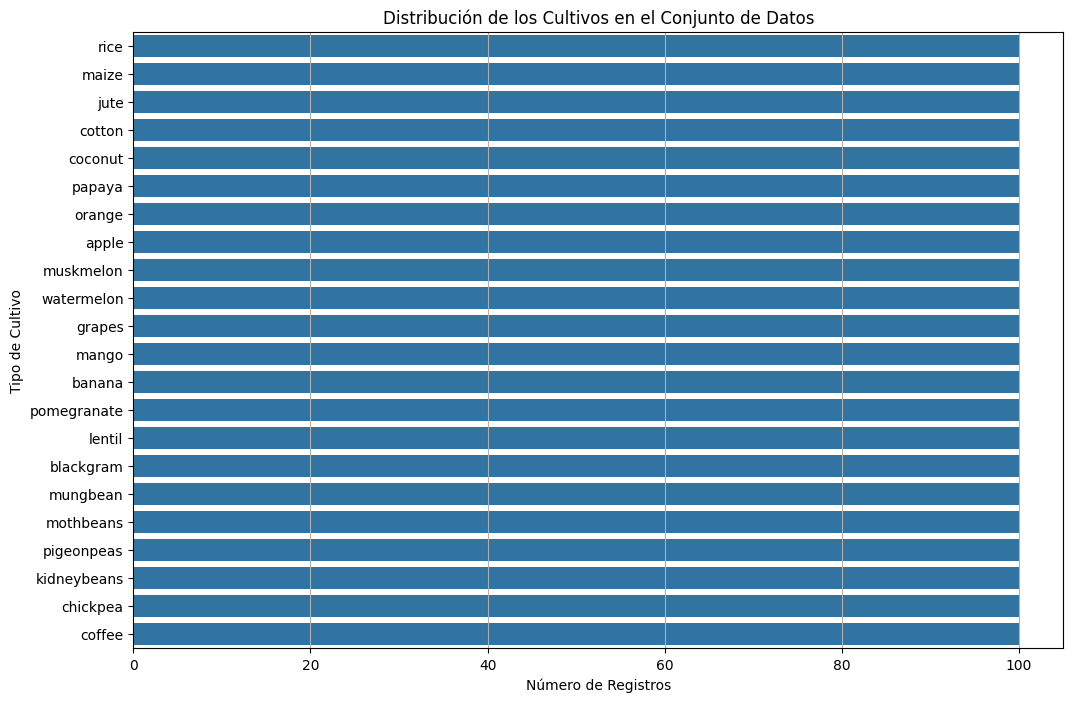

In [183]:
plt.figure(figsize=(12, 8))
sns.countplot(y='crop', data=crops, order = crops['crop'].value_counts().index)
plt.title('Distribución de los Cultivos en el Conjunto de Datos')
plt.xlabel('Número de Registros')
plt.ylabel('Tipo de Cultivo')
plt.grid(axis='x')
plt.show()


Cada tipo de cultivo cuenta con exactamente 100 registros, lo que indica que el conjunto de datos está completamente balanceado. Esta simetría es óptima para análisis y modelado, dado que cada cultivo tiene una representación igualitaria y, por consiguiente, un peso uniforme en cualquier análisis estadístico o modelo predictivo derivado de estos datos.

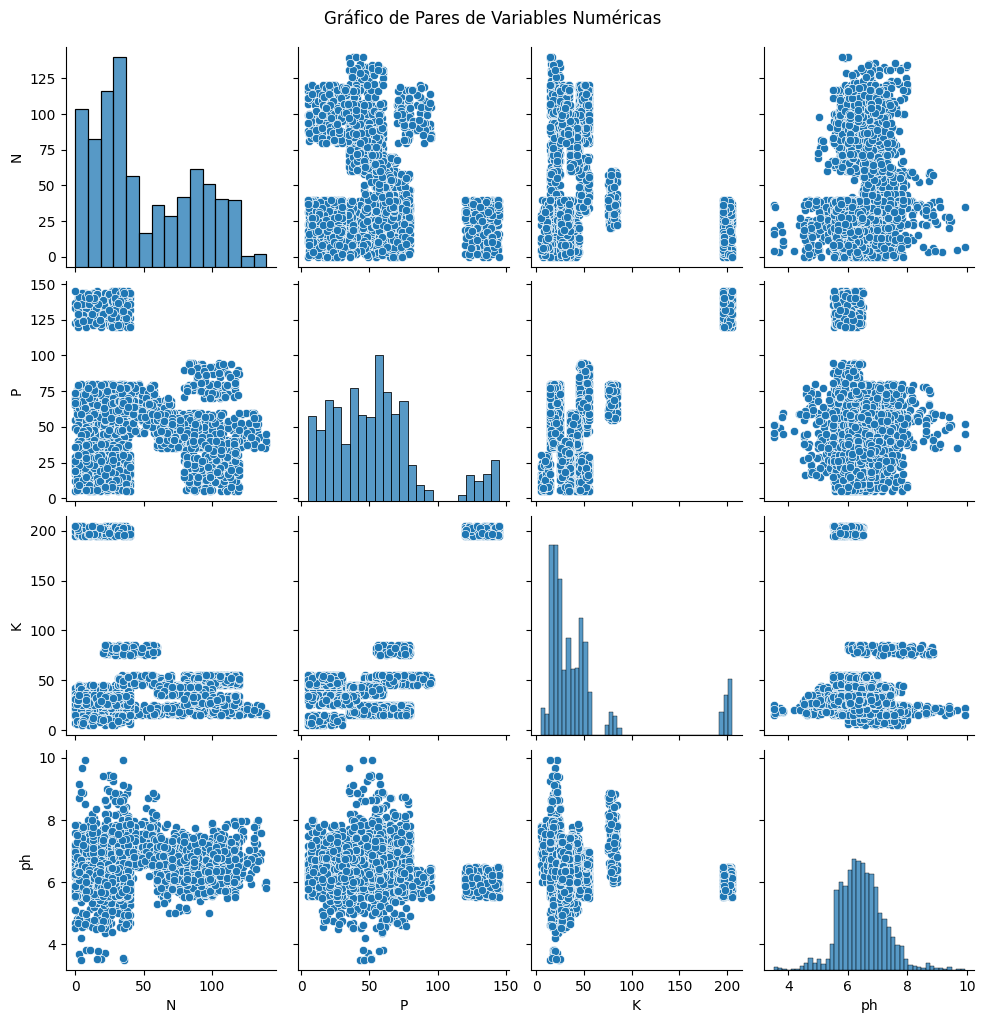

In [184]:
# Calculando el coeficiente de correlación de Pearson
correlation_matrix = crops[['N', 'P', 'K', 'ph']].corr()

# Gráfico de pares para explorar las relaciones
sns.pairplot(crops[['N', 'P', 'K', 'ph']])
plt.suptitle('Gráfico de Pares de Variables Numéricas', y=1.02)  # Ajuste del título para evitar la superposición
plt.show()

Se observa una correlación positiva importante entre los niveles de fósforo (P) y potasio (K), con un coeficiente cercano a 0.736. Esto señala que a medida que aumenta la concentración de fósforo en el suelo, también tiende a incrementarse la concentración de potasio. En contraste, las otras variables no presentan correlaciones significativas entre sí. Por ejemplo, el nitrógeno (N) muestra una débil correlación negativa con P y K, y una débil correlación positiva con el pH, pero estas asociaciones son tenues y sugieren una independencia general entre estas variables.

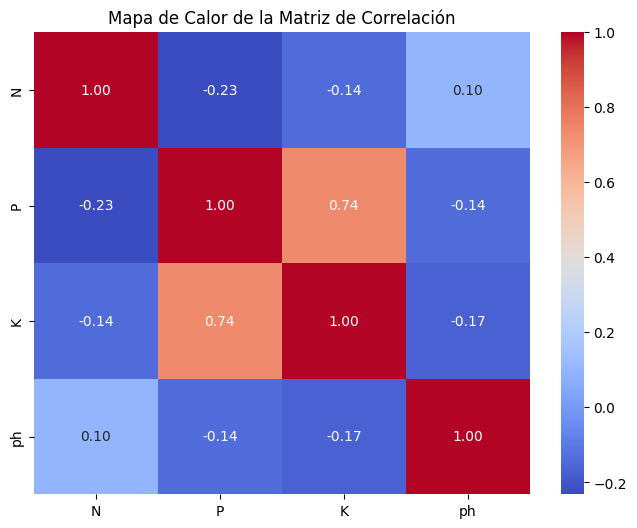

In [185]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

La correlación significativa entre los niveles de fósforo (P) y potasio (K) podría ser relevante en la clasificación de cultivos, especialmente si ciertas plantas tienen preferencias específicas o requisitos particulares en cuanto a estas proporciones de nutrientes. Por otro lado, la falta de correlaciones fuertes entre las demás variables sugiere que cada una podría ofrecer información única sobre las condiciones óptimas para distintos tipos de cultivos.

La independencia observada entre la mayoría de las variables (como N, K y pH) implica que al combinarlas, podríamos potenciar la capacidad de un modelo de ML para clasificar los cultivos, dado que cada una aporta información diferenciada que podría ser crucial para determinar las preferencias de cultivo más adecuadas.

## 3. Modelado y entrenamiento 

Se realizará la división del conjunto de datos de entrenamiento y prueba, escalado y entranamiento de los modelos por ahora más llamativos para una clasificación multiclase. No se hace imputación pues no hay valores pérdidos.

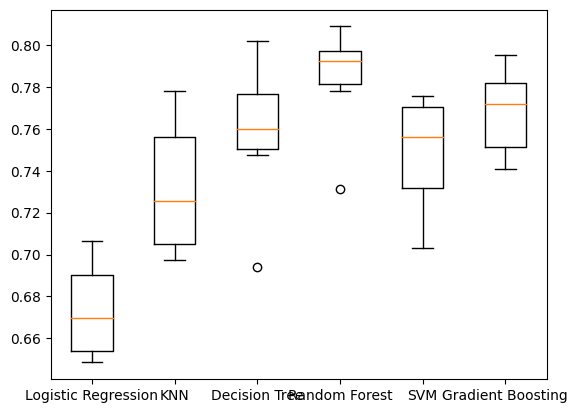

In [186]:
# Entrenamiento

X = crops.drop("crop", axis=1).values
y = crops["crop"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {"Logistic Regression": LogisticRegression(), 
          "KNN": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier(random_state=42),
          "SVM": SVC(),
          "Gradient Boosting": GradientBoostingClassifier(random_state=42)
          }
         
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)
    
plt.boxplot(results, labels=models.keys())
plt.show()

El modelo "Random Forest" destaca por presentar una mediana superior y una variabilidad mínima, lo que indica un rendimiento sólido y consistente en general. Estas características lo posicionan como un fuerte contendiente para ser considerado como el mejor modelo global. 

## 4. Resultados con datos de prueba

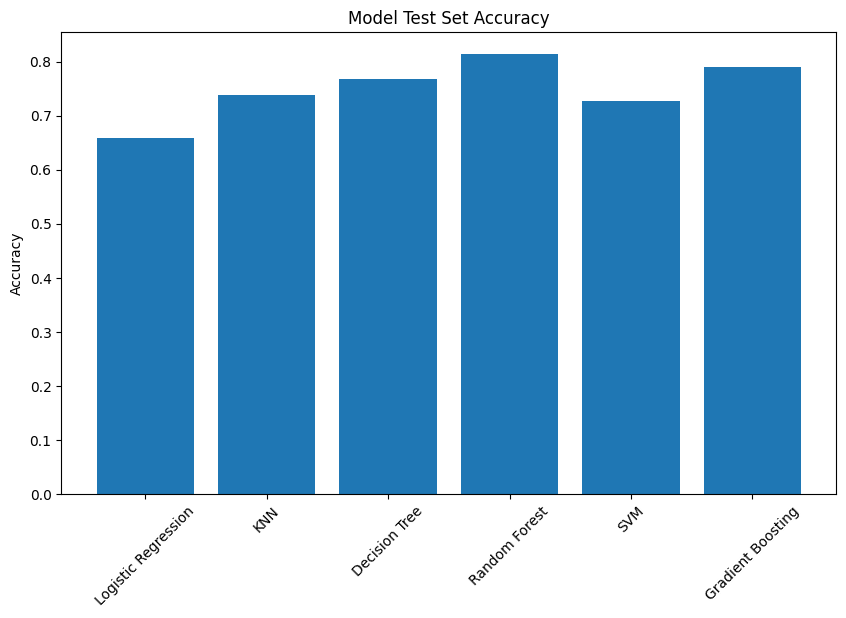

In [187]:
# Prueba

results_test = pd.DataFrame(columns=['model', 'Accuracy'])

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    # Añadiendo los resultados al DataFrame
    results_test = results_test.append({'model': name, 'Accuracy': test_score}, ignore_index=True)

# Creando un gráfico de barras a partir del DataFrame
plt.figure(figsize=(10,6))  # Ajusta el tamaño según necesites
plt.bar(results_test['model'], results_test['Accuracy'])
plt.ylabel('Accuracy')
plt.title('Model Test Set Accuracy')
plt.xticks(rotation=45)  # Rota los nombres de los modelos para mejor visualización
plt.show()

## 5. Ajuste de hiperparámetros

Es factible realizar ajustes de hiperparámetros en los modelos incluido "Random Forest" con el fin de identificar configuraciones que mejoren aún más sus rendimientos. Esta optimización de hiperparámetros es crucial para maximizar la eficacia predictiva de los modelos y adaptarlos de manera más precisa a las necesidades específicas del problema en estudio.

In [188]:
# Diccionario con modelos y sus espacios de hiperparámetros
model_params = {
    "Logistic Regression": (LogisticRegression(max_iter=10000), {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga', "newton-cg", "lbfgs"]}),
    "KNN": (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    "Decision Tree": (DecisionTreeClassifier(), {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}),
    "Random Forest": (RandomForestClassifier(random_state=42), {'n_estimators': [100, 200], 'max_depth': [None, 10], 'min_samples_split': [2, 10], 'min_samples_leaf': [1, 2]}),
    "SVM": (SVC(), {'C': [0.1, 1], 'kernel': ['linear', 'rbf']}),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=42), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]})
}

# Ejecutar GridSearchCV para cada modelo y almacenar los mejores parámetros
best_params = {}
for name, (model, params) in model_params.items():
    gs = GridSearchCV(model, params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    gs.fit(X_train_scaled, y_train)
    best_params[name] = gs.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


## 6. Resultados con ajustes hiperparamétricos

In [189]:
# Inicializa un DataFrame vacío para almacenar todos los reportes
all_reports = pd.DataFrame()

# Iterar sobre los nombres de los modelos y los mejores parámetros encontrados
for name, params in best_params.items():
    # Crear una nueva instancia del modelo con los mejores parámetros
    model = model_params[name][0].set_params(**params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report['model'] = name  # Añade una columna con el nombre del modelo
    all_reports = pd.concat([all_reports, df_report], axis=0)


In [190]:
# Se promedian medidas: Precisión, Recall y F1 Score
average_scores = all_reports.groupby('model')[['precision', 'recall', 'f1-score']].mean().reset_index()

In [191]:
# Inicializar un diccionario para almacenar el accuracy de cada modelo
accuracies = {}

# Asumiendo que best_params contiene los mejores parámetros de GridSearchCV para cada modelo
for name, params in best_params.items():
    # Crear una nueva instancia del modelo con los mejores parámetros
    best_model = model_params[name][0].set_params(**params)
    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)
    
    # Obtener el accuracy para el modelo actual
    accuracy = accuracy_score(y_test, y_pred)
    
    # Almacenar el accuracy en el diccionario con el nombre del modelo como clave
    accuracies[name] = accuracy

# Convertir el diccionario de accuracies en un DataFrame para una fácil visualización y comparación
df_accuracies = pd.DataFrame(list(accuracies.items()), columns=['model', 'Accuracy'])


In [192]:
# Se unifica en un solo df todas las medidas: Precisión, Recall y F1 Score más Accuracy
merged_df = pd.merge(average_scores, df_accuracies, on='model')

## 7. Comparación de Accuracy antes y depsues de ajuste de hiperparámetros

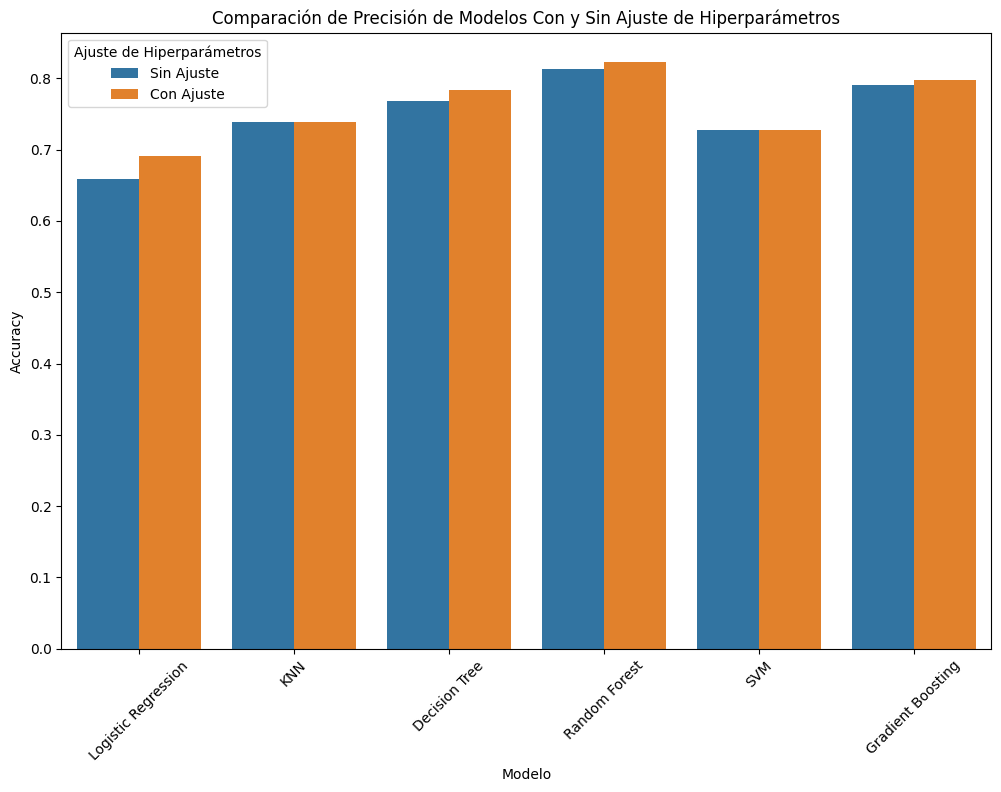

In [193]:
#Se grafíca un comparativo entre el accuracy antes de ajuste de hiperparámetros y depsues
results_test['Adjustment'] = 'Sin Ajuste'
merged_df['Adjustment'] = 'Con Ajuste'

# Paso 2: Unir ambos DataFrames
combined_df = pd.concat([results_test, merged_df])

# Paso 3: Crear el gráfico
plt.figure(figsize=(12, 8))
sns.barplot(data=combined_df, x='model', y='Accuracy', hue='Adjustment')
plt.title('Comparación de Precisión de Modelos Con y Sin Ajuste de Hiperparámetros')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
plt.legend(title='Ajuste de Hiperparámetros')

plt.show()


## 8. Performance o rendimiento de cada modelo evaluado

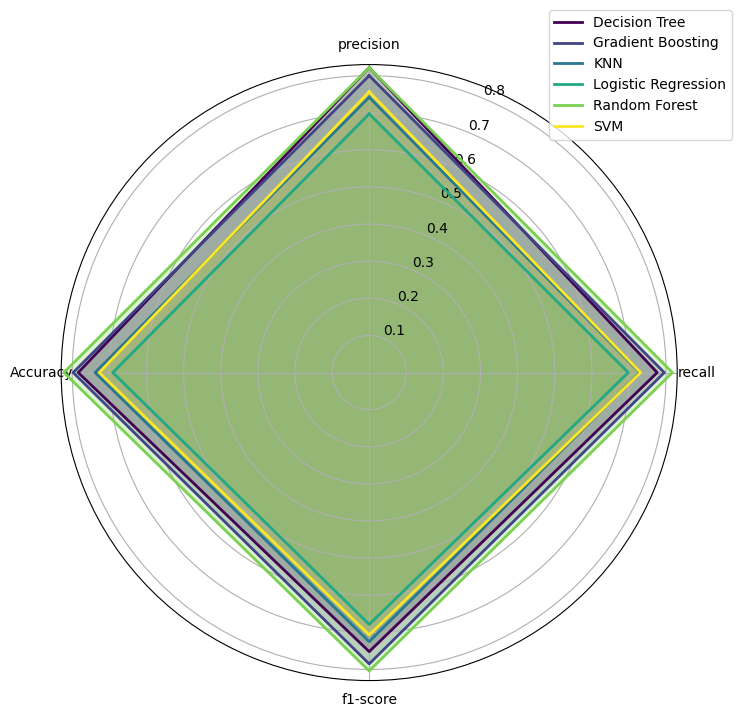

In [194]:
# Se hace una gráfica de telaraña para observar el performance o rendimeinto de cada modelo

# Definir las métricas y los modelos
metrics = ['precision', 'recall', 'f1-score', 'Accuracy']
models = merged_df['model'].tolist()

# Número de variables que comparamos
num_vars = len(metrics)

# Ángulos para cada eje en el gráfico de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Completa el círculo

# Iniciar la figura de radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Lista de colores para cada modelo
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

# Dibujar las líneas para cada modelo
for i, (model, color) in enumerate(zip(models, colors)):
    values = merged_df[merged_df['model'] == model][metrics].values.flatten().tolist()
    values += values[:1]  # Cierra el círculo
    ax.plot(angles, values, color=color, linewidth=2, label=model)
    ax.fill(angles, values, color=color, alpha=0.25)

# Etiquetas para cada eje
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], metrics)

# Añadir leyenda
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()


## 9. Importancia de variables en el modelo con mejor rendimiento

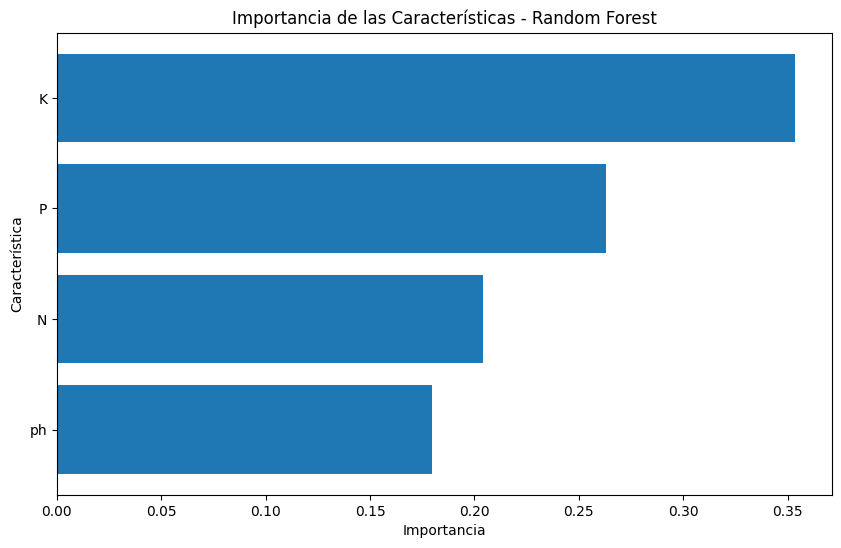

In [195]:
# Se obtiene la importancia de las variables del modelo con mejor rendimeinto

best_rf_model = model_params["Random Forest"][0].set_params(**best_params["Random Forest"])
feature_importances = best_rf_model.feature_importances_

# Obtener los nombres de las características
feature_names = ["N", "P", "K", "ph"]

# Crear un DataFrame para visualizar las importancias de las características
df_feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Visualizar las importancias de las características en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(df_feature_importances['Feature'], df_feature_importances['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las Características - Random Forest')
plt.gca().invert_yaxis()  
plt.show()

## 10. La variable más importante

In [196]:
# se identifica y se guarda en un diccionario la variable más impornate.

max_feature_row = df_feature_importances.loc[df_feature_importances['Importance'].idxmax()]

# Crear un diccionario con la característica más importante y su importancia
best_predictive_feature = {max_feature_row['Feature']: max_feature_row['Importance']}

print(best_predictive_feature)

{'K': 0.3535454555190617}


## 5. Conclusiones

El estudio sobre cómo el aprendizaje automático ayuda a los agricultores a seleccionar los mejores cultivos destaca la importancia de métricas esenciales del suelo, como los niveles de nitrógeno, fósforo, potasio y el valor del pH, para identificar qué tipo de cultivos se adaptan mejor al terreno. A través de la construcción de modelos de clasificación multiclase utilizando datos de medidas del suelo, se logró predecir con éxito el tipo de cultivo óptimo para cada campo.

Tras un análisis exploratorio que reveló la ausencia de desequilibrio de clases y una fuerte correlación entre los elementos fósforo y potasio, se procedió a comparar varios modelos de clasificación, entre los cuales el Random Forest destacó por su rendimiento sólido y consistente. Tras ajustes de hiperparámetros, se logró mejorar la precisión del modelo, alcanzando un rendimiento general del 82.3%, con métricas como precisión, recall y F1_score superiores al 80%.

El Random Forest se identificó como el mejor modelo para clasificar qué tipo de cultivo se adecua mejor al suelo, destacando que la característica más importante para esta clasificación fue el contenido de potasio (K) con un porcentaje de importancia del 35.35%. Este enfoque de aprendizaje automático ofrece a los agricultores una herramienta efectiva para tomar decisiones informadas sobre la selección de cultivos basada en las condiciones del suelo.